In [1]:
import numpy as np
import scipy
import scipy.linalg
import matplotlib.pyplot as plt

# Base class from which our solver inherits
from numerical_eqs.pde.sdole import SDOLEPDESolver

from utils import *



def as_interwoven( M ):
    return M.T.reshape(-1)

def as_stacked( M, bandWidth ):
    return M.reshape(-1, bandWidth).T

In [2]:

class AnelasticSolver(SDOLEPDESolver):
    ########### Boilerplate
    def __init__(self, err_fn = lambda x: np.linalg.norm(x, ord=np.inf)):
        self.errfn = err_fn
    def setup(self, ):
        self.dx = (self.mesh[1:] - self.mesh[:-1])[0]
    def process(self, results):
        results['ys'] = np.asarray(results['ys'])
        results['time'] = np.asarray(results['time'])
        return results
    #################################
    @staticmethod
    def resid(U, dU, dt, dx):
        # Pull out stacked terms
        Uv = U[0]
        Up = U[1]

        dUv = dU[0]
        dUp = dU[1]
        ########
        Rv = 0 * Uv

        Rv[1:] += 1/dt * dUv[1:] + 1/dx * (Up[1:] + dUp[1:] - Up[:-1] - dUp[:-1])
        Rv[0] = dUv[0] + Uv[0]
        Rv[-1] = dUv[-1] + Uv[-1]

        ########
        Rp = 0 * Up

        Rp[:-1] += 1/dt * dUp[:-1] + 1/dx * (Uv[1:] + dUv[1:] - Uv[:-1] - dUv[:-1])
        Rp[-1] = dUp[-1]

        ########

        return np.concatenate([Rv, Rp], axis=0).reshape(2,-1)
    
    
    
    def step_raw(self, x, t, dt):
        U = x
        
        # Get our initial guess
        dU = 0 * U
        R_b = self.resid(U, dU, dt, self.dx)
        R_b = as_interwoven(R_b)

        
        def a_func ( du ):
            du = as_stacked(du, U.shape[0])
            r = self.resid(U, du, dt, self.dx)
            return as_interwoven(r)
            
        A = banded_jacobian_approx(
            f = a_func,
            x0 = as_interwoven( dU ),
            n_low = 1,
            n_high = 1,
            eps=1e-8,
        )
        # Verify that A was built properly
#         print('dx', self.dx, 1/self.dx)
#         print('dt', dt, 1/dt)
#         print('A', A)
        

        dU = scipy.linalg.solve_banded(
            (1, 1),
            A,
            -1 * R_b,
        )
        
        return as_stacked( dU, U.shape[0] )



    def step(self, x, t, dt):
        '''Use Backward Euler
        '''
        U = x
        
        U_course = U + self.step_raw(U, t, dt)
        U_fine_mid = U + self.step_raw(U, t, dt/2.0)
        U_fine = U_fine_mid + self.step_raw(U_fine_mid, t+dt/2.0, dt/2.0)
        
        U_new = 2*U_fine - U_course
        
        U_err = self.errfn(U_fine - U_course)
        return U_new, U_err

In [3]:
# 1 + N
meshsize = 1 + 50
mesh = np.linspace(0, 5, meshsize)
U0 = np.concatenate([
    
    # v component
    0 * mesh,
    
    # p component
    np.where(mesh < 1, (mesh **2  - 1)**2, 0 ),
    
], axis=0).reshape(2,-1)
# plt.plot(mesh, U0[1])


dt = 0.05
t0, t1 = (0, 6)

plot_points = np.linspace(t0, t1, 10)
# Points in time that will be explicitly plotted below
time_points = [0,2,4,6]


explicit_times = {
    'time points': time_points + plot_points.tolist(),
}



# These are useless in this iteration
boundaries = (
    {'type': 'neumann', 'f': lambda t: 0},
    {'type': 'neumann', 'f': lambda t: 0},
)


pde = AnelasticSolver()
res = pde.solve(
    mesh = mesh,
    u0 = U0,
    t0 = t0,
    t1 = t1,
    # Add in boundaries
    boundaries = boundaries,
    
    explicit_times = explicit_times,
    # Show the progress bar
    progress = True,
    
    # Just disable step doubling
    time_controls = {
        'dtmin': dt,
        'dtmax': dt
    }
)


sol_y = res['ys'][:,1,:]
sol_t = res['time']

100%|██████████| 6.0/6 [00:00<00:00, 23.21it/s]               


(array([  0,  14,  28,  42,  56,  70,  84,  98, 112, 126]),)
(10, 51)


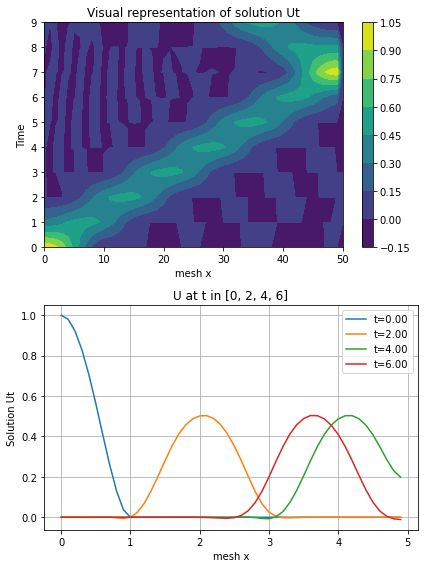

In [4]:


k = 2
cols = 1
rows = int(np.ceil(k / cols))
fig, axs = plt.subplots(rows, cols, figsize=(6*cols,4*rows))
axs = np.asarray(axs).flatten()


j = np.zeros(sol_t.shape)
for t in plot_points:
    j = np.logical_or(j, sol_t == t)

# Find times that satisfy
times = np.nonzero( j )
print(times)

plt_data = sol_y[times, :][0,:,:]
print(plt_data.shape)
# Plot this using the colorbar
cf = axs[0].contourf(
    plt_data
)
fig.colorbar(cf, ax=axs[0])
axs[0].set_title('Visual representation of solution Ut')
axs[0].set_xlabel('mesh x')
axs[0].set_ylabel('Time')





j = np.zeros(sol_t.shape)
for t in time_points:
    j = np.logical_or(j, sol_t == t)

# Find times that satisfy
times = np.asarray(np.nonzero( j )).flatten()

for i, t in zip(times, time_points):
    axs[1].plot(
        mesh[:-1],
        sol_y[i,:-1],
        label='t={0:.2f}'.format(t)
    )

axs[1].set_title('U at t in {0}'.format(time_points))
axs[1].set_xlabel('mesh x')
axs[1].set_ylabel('Solution Ut')
axs[1].legend()
axs[1].grid()


fig.tight_layout()
plt.show()

None